In [10]:
import matplotlib.pyplot as plt
import numpy as np

from intermodulation.utils import get_nearest_f

%matplotlib inline


def flip_state(t, target_t, keymask, framerate):
    close_enough = np.isclose(t, target_t, rtol=0.0, atol=1 / (2 * framerate) - 1e-6)
    past_t = t > target_t
    goodclose = (close_enough & keymask) | (past_t & keymask)
    # breakpoint()
    if np.any(goodclose):
        ts_idx = np.argwhere(goodclose).flatten()[-1]
        keymask[ts_idx] = False
        return True, keymask
    return False, keymask

In [11]:
f_vals = np.arange(4, 61, 1)

actual_frs_nonoise = []
allflips = []
alltargets = []

framerate = 120
dur = 3.0
t_vals = np.arange(0, dur, (1 / framerate))
for f in f_vals:
    flips = []
    target_ts = np.arange(0, 100, 1 / (2 * f))
    alltargets.append(target_ts)
    keymask = np.ones_like(target_ts).astype(bool)
    t_last = 0.0
    for t in t_vals:
        flip, keymask = flip_state(t, target_ts, keymask, framerate)
        if flip:
            flips.append(t)
    allflips.append(np.array(flips))
    actual_frs_nonoise.append(np.mean(1 / np.diff(flips) / 2))

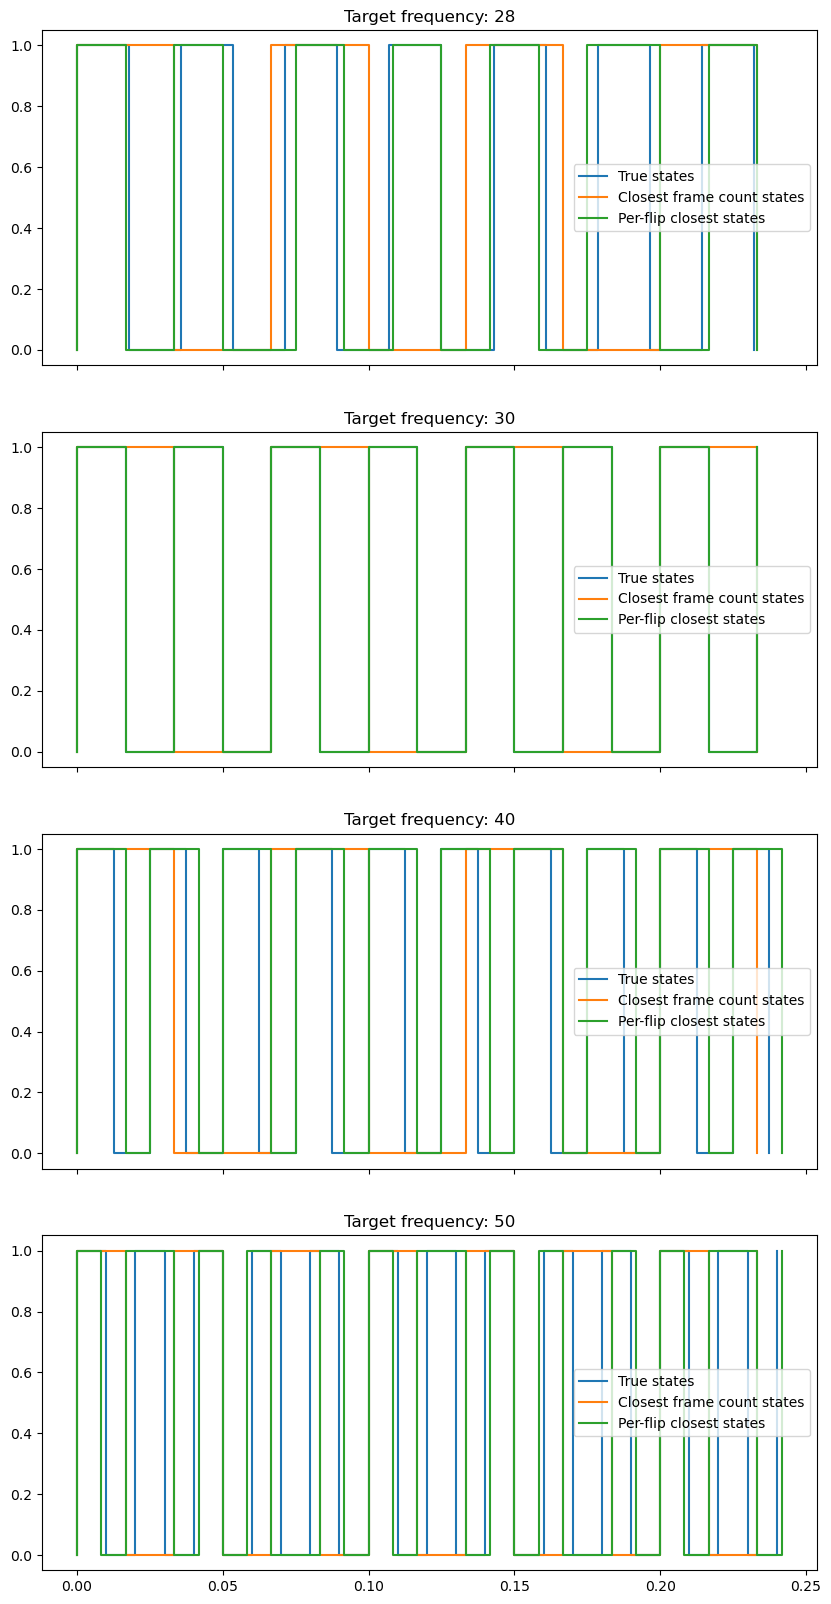

In [26]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10, 20))
ax = ax.flatten()
plot_duration = 0.25
plot_t = np.linspace(0, plot_duration, 1000)
for i, (f, idx) in enumerate([(28, 24), (30, 26), (40, 36), (50, 46)]):
    ax[i].set_title("Target frequency: " + str(f))
    for name, t in {
        "True": alltargets[idx],
        "Closest frame count": np.arange(0, plot_duration, 1 / (get_nearest_f(f, framerate))),
        "Per-flip closest": allflips[idx],
    }.items():
        targetmask = t < plot_duration
        target_ts = np.hstack([np.array((0)), t[targetmask]])
        states = np.ones_like(target_ts, dtype=bool)
        states[::2] = False
        wheres = np.ones_like(target_ts, dtype=bool)
        wheres[::3] = False
        ax[i].step(target_ts, states, where="post", label=name + " states")
        ax[i].fill_between(target_ts, 0, 1, where=states, alpha=0.5)
    ax[i].legend()

In [14]:
target_ts

array([0.        , 0.00833333, 0.025     , 0.03333333, 0.05      ,
       0.05833333, 0.06666667, 0.08333333, 0.09166667, 0.10833333,
       0.11666667, 0.125     , 0.14166667, 0.15      , 0.16666667,
       0.175     , 0.18333333, 0.2       , 0.20833333, 0.225     ,
       0.23333333, 0.24166667, 0.25833333, 0.26666667, 0.275     ,
       0.29166667, 0.3       , 0.31666667, 0.325     , 0.33333333,
       0.35      , 0.35833333, 0.375     , 0.38333333, 0.39166667,
       0.40833333, 0.41666667, 0.43333333, 0.44166667, 0.45      ,
       0.46666667, 0.475     , 0.49166667, 0.5       , 0.50833333,
       0.525     , 0.53333333, 0.55      , 0.55833333, 0.56666667,
       0.58333333, 0.59166667, 0.60833333, 0.61666667, 0.625     ,
       0.64166667, 0.65      , 0.66666667, 0.675     , 0.68333333,
       0.7       , 0.70833333, 0.725     , 0.73333333, 0.74166667,
       0.75833333, 0.76666667, 0.775     , 0.79166667, 0.8       ,
       0.81666667, 0.825     , 0.83333333, 0.85      , 0.85833